# Q1:

In this implementation, we aim to transition from a standard Gibbs sampler to a Metropolis within Gibbs sampler by modifying the sampling approach for the parameter $\tau$ .Instead of directly deriving the full conditional distributions, we utilize Metropolis-Hastings (MH) within Gibbs for $\tau$ , while maintaining standard Gibbs sampling for $\theta$ .
The acceptance probability is computed as:
$$
A(\tau^* | \tau^{(t-1)}) = \min \left( 1, \frac{P(\tau^* | x, \theta)}{P(\tau^{(t-1)} | x, \theta)} \times \frac{q(\tau^{(t-1)})}{q(\tau^*)} \right)
$$
Given $\tau$, the full conditional of $\theta$ remains a normal distribution:
$$
\theta | x, \tau \sim \mathcal{N} \left( \frac{n \bar{x} \tau}{n \tau + 1}, \frac{1}{n \tau + 1} \right)
$$
Gibbs sampling is generally more efficient than Metropolis-Hastings because every proposed sample is accepted, whereas Metropolis-Hastings can reject proposals, potentially slowing down convergence. In terms of mixing and convergence, Gibbs sampling directly samples from the conditional posteriors, leading to faster mixing, while Metropolis-Hastings might experience slow mixing if the proposal distribution is not well chosen.

However, in terms of flexibility, Metropolis-Hastings can be applied in cases where Gibbs sampling is not feasible, such as when full conditional distributions are difficult to sample from, making it a more general approach. On the other hand, Gibbs sampling requires explicit knowledge of the exact conditional distributions, which may not always be available in complex models.

<ipython-input-2-d2f02efe058a>:30: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_probability = min(1, joint_prob_proposed / joint_prob_current)


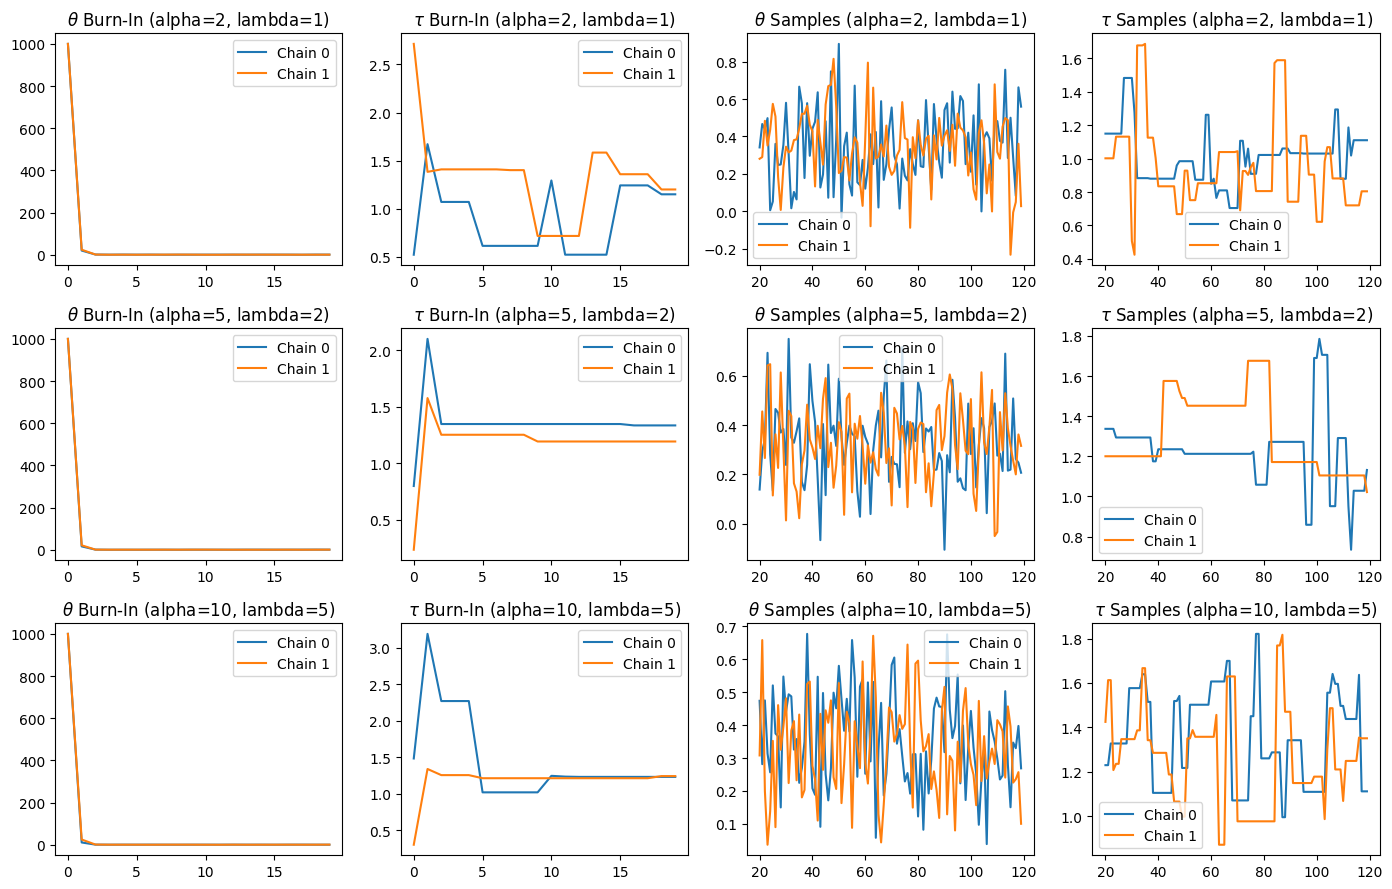

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Data
n = 30
x = stats.norm(loc=0, scale=1).rvs(size=n)
C, G = 2, 10000  # Chains, Gibbs samples

# Different hyperparameter settings for prior influence
hyperparameter_settings = [(2, 1), (5, 2), (10, 5)]  # (alpha, lambda_param) pairs
results = {}

for alpha, lambda_param in hyperparameter_settings:
    theta, tau = np.zeros([C, G]), np.zeros([C, G])
    theta[:, 0] = 1000  # Initialization
    tau[:, 0] = stats.expon(scale=1).rvs(size=C)  # Ensure positive initial tau

    for c in range(C):
        for g in range(1, G):
            # Metropolis-Hastings step for tau using independent proposal distribution
            tau_proposal = stats.gamma(a=alpha, scale=1/lambda_param)  # Independent proposal
            tau_tilde = tau_proposal.rvs()

            joint_prob_current = np.prod(stats.norm(loc=theta[c, g-1], scale=1/np.sqrt(tau[c, g-1])).pdf(x)) * \
                               stats.gamma(a=alpha, scale=1/lambda_param).pdf(tau[c, g-1])
            joint_prob_proposed = np.prod(stats.norm(loc=theta[c, g-1], scale=1/np.sqrt(tau_tilde)).pdf(x)) * \
                                 stats.gamma(a=alpha, scale=1/lambda_param).pdf(tau_tilde)

            acceptance_probability = min(1, joint_prob_proposed / joint_prob_current)
            if stats.uniform().rvs() < acceptance_probability:
                tau[c, g] = tau_tilde
            else:
                tau[c, g] = tau[c, g-1]

            # Gibbs sampling step for theta
            tau_factor = tau[c, g] * n
            mean_theta = (np.mean(x) * tau_factor + theta[c, g - 1]) / (tau_factor + 1)
            std_theta = (1 / (tau_factor + 1)) ** 0.5
            theta[c, g] = stats.norm(loc=mean_theta, scale=std_theta).rvs()

    results[(alpha, lambda_param)] = (theta, tau)

# Plot results for different hyperparameter settings
fig, axes = plt.subplots(len(hyperparameter_settings), 4, figsize=(14, 3 * len(hyperparameter_settings)))
burn = 20
demo = 120

for i, (alpha, lambda_param) in enumerate(hyperparameter_settings):
    theta, tau = results[(alpha, lambda_param)]
    axes[i, 0].set_title(f"$\\theta$ Burn-In (alpha={alpha}, lambda={lambda_param})")
    axes[i, 1].set_title(f"$\\tau$ Burn-In (alpha={alpha}, lambda={lambda_param})")
    axes[i, 2].set_title(f"$\\theta$ Samples (alpha={alpha}, lambda={lambda_param})")
    axes[i, 3].set_title(f"$\\tau$ Samples (alpha={alpha}, lambda={lambda_param})")

    for c in range(C):
        axes[i, 0].plot(theta[c, :burn], label=f"Chain {c}")
        axes[i, 1].plot(tau[c, :burn], label=f"Chain {c}")
        axes[i, 2].plot(np.arange(burn, demo, dtype=int), theta[c, burn:demo], label=f"Chain {c}")
        axes[i, 3].plot(np.arange(burn, demo, dtype=int), tau[c, burn:demo], label=f"Chain {c}")

    for j in range(4):
        axes[i, j].legend()

plt.tight_layout()
plt.show()



# Q2:
## Choose Gamma distribution as prior distribution

In our implementation, we apply Metropolis-Hastings within Gibbs sampling by using a dependent truncated normal proposal for $\tau$, ensuring that it remains positive while allowing for efficient exploration of the posterior distribution. Since the full conditional distribution of $\tau$ is non-trivial and does not have a standard closed-form solution, we approximate it using Metropolis-Hastings, where each proposed $\tau*$ is accepted or rejected based on an acceptance probability that accounts for both the likelihood and the prior. For $\theta$, instead of a normal prior, we use a Gamma prior, which better aligns with cases where $\theta$ is constrained to be positive. This adjustment allows for greater flexibility in modeling and ensures that the prior more accurately reflects domain-specific knowledge.

The necessity of analytically determining full conditional distributions in Gibbs sampling depends on whether they have standard forms that allow for direct sampling. When such distributions exist, Gibbs sampling is computationally efficient because it avoids the rejection steps inherent in Metropolis-Hastings. However, when full conditionals are intractable, Metropolis-Hastings becomes essential, as demonstrated in our approach for $\tau$. This hybrid strategy balances feasibility and accuracy, making Gibbs sampling applicable even in complex Bayesian models where direct sampling is not possible. Through our implementation, we demonstrate how the choice of priors and proposal distributions impacts convergence, mixing efficiency, and the quality of inference.

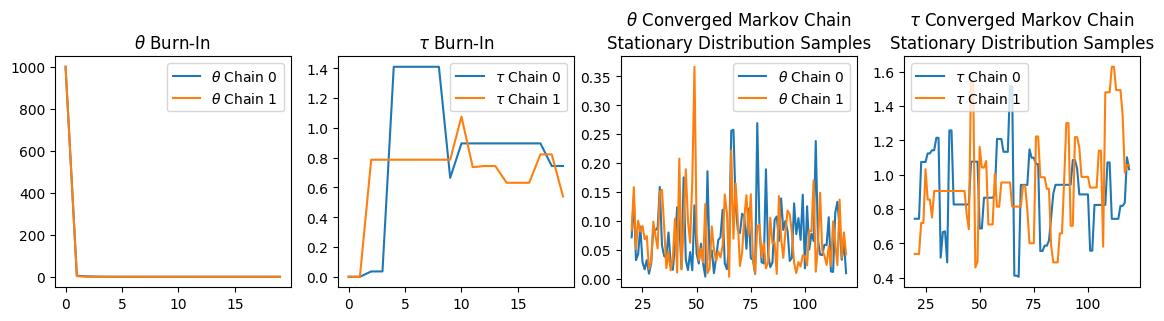

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Generate observed data
n = 30
x = stats.norm(loc=0, scale=1).rvs(size=n)
C, G = 2, 10000  # Number of chains and Gibbs samples

# Initialize storage arrays
theta, tau = np.zeros([C, G]), np.zeros([C, G])
theta[:, 0] = 1000  # Initial theta values
s = 1  # Scale parameter for truncated normal proposal in Metropolis-Hastings

alpha = 2  # Hyperparameter for the Gamma prior
lambda_param = 1  # Hyperparameter for the Gamma prior

for c in range(C):
    for g in range(1, G):
        # ---- Metropolis-Hastings step for tau using dependent proposal ----
        tau_t_minus_1 = tau[c, g - 1]
        tau_t_minus_1 = max(tau_t_minus_1, 1e-6)  # Ensure positivity

        # Define truncated normal proposal distribution for tau
        a, b = (-tau_t_minus_1/s, np.inf)  # Ensure positivity
        tau_proposal = stats.truncnorm(a, b, loc=tau_t_minus_1, scale=s)
        tau_tilde = tau_proposal.rvs()

        # Define the target distribution for tau
        def tau_target(tau_):
            return np.prod(stats.norm(loc=theta[c, g - 1], scale=1/np.sqrt(tau_)).pdf(x)) * \
                   stats.gamma(a=alpha, scale=1/lambda_param).pdf(tau_)  # Prior for tau

        # Compute the Metropolis-Hastings acceptance ratio
        mh_calc = (tau_target(tau_tilde) / tau_target(tau_t_minus_1)) * \
                  (tau_proposal.pdf(tau_t_minus_1) / tau_proposal.pdf(tau_tilde))

        # Accept or reject the proposed tau
        acceptance_probability = min(1, mh_calc)
        if stats.uniform().rvs() < acceptance_probability:
            tau[c, g] = tau_tilde
        else:
            tau[c, g] = tau_t_minus_1

        # ---- Gibbs sampling step for theta using a Gamma prior ----
        theta_shape = 2.0  # Shape parameter for Gamma distribution
        theta_scale = 1.0 / (max(tau[c, g], 1e-6) * n + 1)  # Scale parameter
        theta[c, g] = stats.gamma(a=theta_shape, scale=theta_scale).rvs()

# ---- Plot results to check convergence ----
fig, ax = plt.subplots(1, 4, figsize=(14, 3))
ax[0].set_title("$\\theta$ Burn-In")
ax[1].set_title("$\\tau$ Burn-In")
ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples")
ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

burn = 20  # Burn-in period
demo = 120  # Number of samples to visualize

for c in range(C):
    ax[0].plot(theta[c, :burn], label="$\\theta$ Chain " + str(c))
    ax[1].plot(tau[c, :burn], label="$\\tau$ Chain " + str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c, burn:demo], label="$\\theta$ Chain " + str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c, burn:demo], label="$\\tau$ Chain " + str(c))

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
plt.show()



# Q3:
In the Metropolis-Hastings algorithm, the acceptance probability is given by:
$$
A(x^{(t-1)}, \tilde{x}^{(t)}) = \min \left( 1, \frac{p(\tilde{x}^{(t)}) q(x^{(t-1)} | \tilde{x}^{(t)})}{p(x^{(t-1)}) q(\tilde{x}^{(t)} | x^{(t-1)})} \right)
$$
We are given the following proposal distribution:
$$
q(\tilde{x}^{(t)} | x^{(t-1)}) = \left(\frac{1}{2}\right)^{1 - \tilde{x}^{(t)}} \cdot \left(\frac{1}{2}\right)^{\tilde{x}^{(t)}}
$$
And the stationary distribution:
$$
p(x^{(t)}) = \left(\frac{1}{3}\right)^{1 - x^{(t)}} \cdot \left(\frac{2}{3}\right)^{x^{(t)}}
$$
We substitute these into the acceptance probability formula:
$$
A(x^{(t-1)}, \tilde{x}^{(t)}) = \min \left( 1, \frac{\left(\frac{1}{3}\right)^{1 - \tilde{x}^{(t)}} \left(\frac{2}{3}\right)^{\tilde{x}^{(t)}} \cdot q(x^{(t-1)} | \tilde{x}^{(t)})}{\left(\frac{1}{3}\right)^{1 - x^{(t-1)}} \left(\frac{2}{3}\right)^{x^{(t-1)}} \cdot q(\tilde{x}^{(t)} | x^{(t-1)})} \right)
$$
As both ${q(x^{(t-1)} | \tilde{x}^{(t)})}$ and ${q(\tilde{x}^{(t)} | x^{(t-1)})}$ both follow uniform distribution (q = 1/2), which is a symmetric proposal distribution.The proposal probabilities therefore cancel out, and the acceptance ratio depends only on the target distribution $p(x^{(t)})$.
$$
\frac{q(x^{(t-1)} | \tilde{x}^{(t)})}{q(\tilde{x}^{(t)} | x^{(t-1)})} = 1
$$
$$
A(x^{(t-1)}, \tilde{x}^{(t)}) = \min \left( 1, \frac{p(\tilde{x}^{(t)})}{p(x^{(t-1)})} \right)
$$
Consider the probability of transitioning from state $s_1$ to itself:
$$
\Pr(s_1 \to s_1) = q(\tilde{x}^{(t)} = 1 | x^{(t-1)} = 1) + q(\tilde{x}^{(t)} = 0 | x^{(t-1)} = 1) \cdot \left( 1 - \frac{p(\tilde{x}^{(t)} = 0)}{p(x^{(t-1)} = 1)} \right)
$$
Substituting the given values:
$$
= \frac{1}{2} + \left( \frac{1}{2} \right) \left( 1 - \frac{(1/3)}{(2/3)} \right) = 0.75
$$
This confirms the correctness of the transition probabilities.

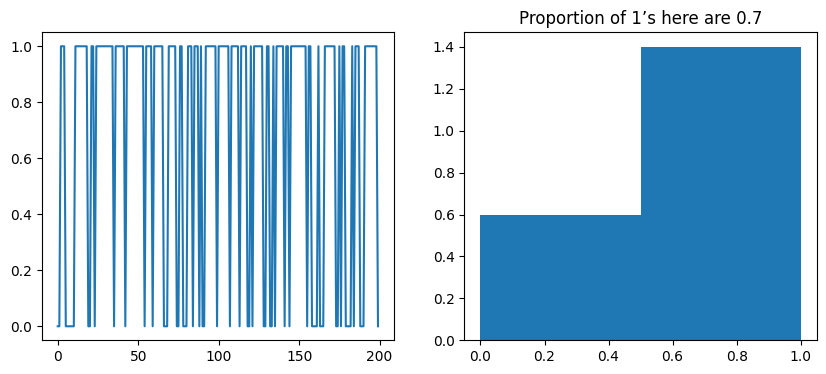

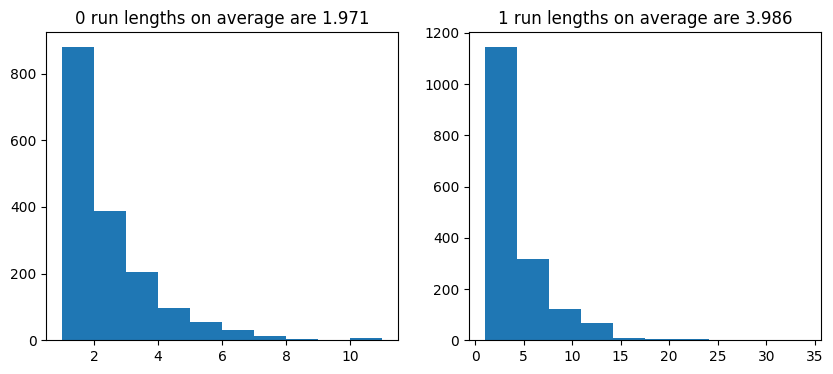

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Define the transition matrix K
K = np.array([[0.5, 0.25],  # P(0 -> 0) = 0.5, P(1 -> 0) = 0.25
              [0.5, 0.75]])  # P(0 -> 1) = 0.5, P(1 -> 1) = 0.75

# ---- Simulation 1: Small T for quick visualization ----
T = 200
s_t = np.zeros(T, dtype=int)  # Initialize state sequence
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:, s_t[t-1]][1])

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(s_t)
ax[1].hist(s_t, bins=2, density=True)
ax[1].set_title("Proportion of 1’s here are " + str(s_t.mean()))

# ---- Simulation 2: Large T to analyze state run lengths ----
T = 10000
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:, s_t[t-1]][1])

# Compute run lengths of 0s and 1s
state0_run_length = []
state1_run_length = []
run_length = 1

for t in range(1, T):
    if s_t[t] == s_t[t-1]:
        run_length += 1
    else:
        if s_t[t-1] == 0:
            state0_run_length.append(run_length)
        else:
            state1_run_length.append(run_length)
        run_length = 1  # Reset counter

# Plot histograms of run lengths
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(state0_run_length)
ax[0].set_title("0 run lengths on average are " + str(np.mean(state0_run_length).round(3)))
ax[1].hist(state1_run_length)
ax[1].set_title("1 run lengths on average are " + str(np.mean(state1_run_length).round(3)))
plt.show()
